In [3]:
import pyro
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro_mixture_model import MixtureModel, MixtureModelGuide
from Preprocess_data import create_summed_df

c:\Users\marie\miniconda3\envs\mbml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and prepare it

In [4]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

Loading data file


In [5]:
def summarize_columns(df):
    excluded_column = "embedding"
    columns_to_summarize = [c for c in df.columns if c != excluded_column]
    
    print(pd.DataFrame([
        (
            c,
            df[c].dtype,
            len(df[c].unique()),
            df[c].memory_usage(deep=True) // (1024**2)
        ) for c in columns_to_summarize
    ], columns=['name', 'dtype', 'unique', 'size (MB)']))
    
    print('Total size (excluding "embedding"):', 
          df[columns_to_summarize].memory_usage(deep=True).sum() / 1024**2, 'MB')

# Call the function
summarize_columns(df)


                           name     dtype  unique  size (MB)
0                    Patient ID  category  325666         30
1           Aktionsdiagnosekode  category    8125          1
2  totalDiagnoseKontaktVarighed   float32    7831          1
3                antalKontakter     int64     142          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   13870          4
6                        gender  category       4          0
7                    civilStand  category       9          0
8          distanceToHospitalKM   float64    1688          3
Total size (excluding "embedding"): 50.16899013519287 MB


### Create train and test data split

In [12]:
def make_demographic_features(df):
    # Create dummy variables for categorical features
    df = pd.get_dummies(df, columns=["gender", "civilStand"], drop_first=True)
    
    # Ensure all columns in demographic_columns are numeric
    demographic_columns = ["alder", "distanceToHospitalKM"] + [col for col in df.columns if col.startswith("gender_") or col.startswith("civilStand_")]

    # Check for non-numeric columns
    for col in demographic_columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Column {col} is not numeric. Converting to numeric.")
            df[col] = pd.to_numeric(df[col], errors="coerce")  # Convert to numeric, setting invalid values to NaN

    # Handle missing values (e.g., fill NaN with 0)
    df[demographic_columns] = df[demographic_columns].fillna(0)

    summarize_columns(df)
    
    return df[demographic_columns].values.astype(np.float32)


In [13]:
# set random seed for reproducibility
np.random.seed(42)

# Convert list of lists to a 2D NumPy array
embedding_length = len(df["embedding"].iloc[0])  # Assuming all embeddings should have the same length
df["embedding"] = df["embedding"].apply(lambda x: x if len(x) == embedding_length else [0.0] * embedding_length)
embeddings = np.array(df["embedding"].tolist(), dtype=np.float32)
embedding_tensor = torch.from_numpy(embeddings)

# Make vector for each row with alder, gender (one hot encoding), civilStand (one hot encoding), distanceToHospitalKM
demographic_data = torch.from_numpy(make_demographic_features(df))

# 1. Convert target to numpy
y_time = torch.from_numpy(df['totalDiagnoseKontaktVarighed'].values.astype(np.float32))
y_count = torch.from_numpy(df["antalKontakter"].values.astype(np.int16))

# 2. Randomly select 1000 indices
total_samples = 100000
all_indices = np.arange(len(embedding_tensor))

selected_indices = np.random.choice(all_indices, size=total_samples, replace=False)
df_subset = df.iloc[selected_indices]

# Select based on patient ID, can't have same patient in train and test
unique_patient_ids = df_subset['Patient ID'].unique()

train_patient_ids, test_patient_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42
)
train_mask = df_subset['Patient ID'].isin(train_patient_ids)
test_mask = df_subset['Patient ID'].isin(test_patient_ids)

# Use the mask to filter rows
x_emb_train = embedding_tensor[selected_indices][train_mask.values]
d_demo_train = demographic_data[selected_indices][train_mask.values]
v_time_train = y_time[selected_indices][train_mask.values]
a_count_train = y_count[selected_indices][train_mask.values]

x_emb_test = embedding_tensor[selected_indices][test_mask.values]
d_demo_test = demographic_data[selected_indices][test_mask.values]
v_time_test = y_time[selected_indices][test_mask.values]
a_count_test = y_count[selected_indices][test_mask.values]

                                  name     dtype  unique  size (MB)
0                           Patient ID  category  325666         30
1                  Aktionsdiagnosekode  category    8125          1
2         totalDiagnoseKontaktVarighed   float32    7831          1
3                       antalKontakter     int64     142          3
4                       antalDiagnoser     int64      17          3
5                                alder   Float64   13870          4
6                 distanceToHospitalKM   float64    1688          3
7                        gender_Kvinde      bool       2          0
8                          gender_Mand      bool       2          0
9                        gender_Ukendt      bool       2          0
10                      civilStand_Død      bool       2          0
11            civilStand_Enke/enkemand      bool       2          0
12                 civilStand_Fraskilt      bool       2          0
13                     civilStand_Gift      bool

## Train

**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2b) Draw $\eta_g \sim \mathcal{N}(0,\bm{I}_K)$

3) For each patient, $p$, in patients:

    3a) Draw group assignment $\bm{g}_p \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^g + \bm{\beta}_x^g \bm{x}_p + \bm{\beta}_d^g \bm{d}_p$

    3c) $\tilde{\Sigma} = \eta_{0}^g + \bm{\eta}_x^g \bm{x}_p + \bm{\eta}_d^g \bm{d}_p$

    3b) Draw $\bm{v}_p \sim \text{LogNormal}(\tilde{\mu}, \tilde{\Sigma})$ 

In [ ]:
pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)

x_emb_train = x_emb_train.to(device)
d_demo_train = d_demo_train.to(device)
v_time_train  = v_time_train.to(device)
a_count_train = a_count_train.to(device)

G=10

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=Trace_ELBO())
losses = []

# Example training loop
def train(num_steps=1000):
    for step in range(num_steps):
        loss = svi.step(x_emb_train, d_demo_train, v_time_train, a_count_train, G, device)
        losses.append(loss)
        
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

# To run:
train(1000)  # adjust steps
# After training, inspect pyro.param values for cluster parameters and q_alpha

# 9 minutes on GPU, 1000 samples, 10000 steps
# 4 minutes on GPU, 100000 samples, 1000 steps

Using device: cuda
Step 0 : loss = 172781211336.35022
Step 100 : loss = 10020041807910.898
Step 200 : loss = 223796387895.72806
Step 300 : loss = 1035313366235.8635
Step 400 : loss = 12085751835642.01
Step 500 : loss = 208076634093.71194
Step 600 : loss = 20507264838.667713
Step 700 : loss = 134668085707.7855
Step 800 : loss = 339264148642.4559
Step 900 : loss = 68935893565.98114


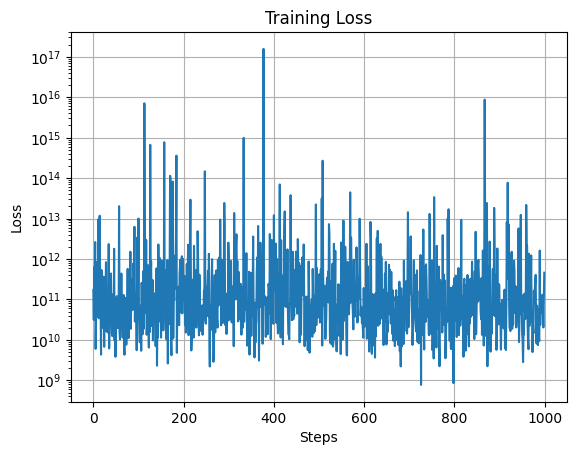

In [11]:
# plot loss
import matplotlib.pyplot as plt
def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.yscale("log")
    plt.grid()
    plt.show()

# Call the function to plot loss
plot_loss(losses)

In [10]:
# Plot predictions on test set
x_emb_test = x_emb_test.to(device).to(torch.float64)
d_demo_test = d_demo_test.to(device).to(torch.float64)
v_time_test = v_time_test.to(device).to(torch.float64)
a_count_test = a_count_test.to(device).to(torch.float64)

predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      # number of posterior draws
    return_sites=["obs_time", "obs_visits"]
)

# 3. Draw posterior‐predictive samples
samples = predictive(x_emb_test, d_demo_test, None, None, device)

# 4. Compute the posterior mean prediction for each outcome
pred_time   = samples["obs_time"].mean(dim=0).cpu().numpy()
pred_visits = samples["obs_visits"].mean(dim=0).cpu().numpy()

# 5. Get the “true” values
true_time   = v_time_test.cpu().numpy()
true_visits = a_count_test.cpu().numpy()

# 6. Plot True vs Predicted for time
plt.figure()
plt.scatter(true_time, pred_time)
plt.plot([true_time.min(), true_time.max()],
         [true_time.min(), true_time.max()],
         linewidth=1)
plt.xlabel("True Time Spent")
plt.ylabel("Predicted Time Spent")
plt.title("True vs Predicted Time Spent")

# 7. Plot True vs Predicted for visits
plt.figure()
plt.scatter(true_visits, pred_visits)
plt.plot([true_visits.min(), true_visits.max()],
         [true_visits.min(), true_visits.max()],
         linewidth=1)
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.title("True vs Predicted Number of Visits")

plt.show()

TypeError: ones() received an invalid combination of arguments - got (torch.device, device=str, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
